<a href="https://colab.research.google.com/github/martaarozarena/KSchool-Master-Final-Project/blob/master/exog_varaibles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta, date
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 8)

In [158]:
# We select the countries and dates our project will focus on:

countries = 'Denmark|Germany|Spain|Finland|Italy|Sweden|France|Norway|United Kingdom' \
            '|United States|Canada|Mexico' \
            '|Australia|Indonesia|Malaysia|Philippines|Thailand|Hong Kong|Vietnam|China|India|Japan|Singapore|Taiwan' \
            '|Saudi Arabia|United Arab Emirates'
initialdate = '2020-01-01'   # first day of the year, where most of our data starts
enddate = str(date.fromordinal(date.today().toordinal()-1))   # yesterday's date: last day of available data

# Downloading and preparing the Oxford Covid Policy Tracker data

In [286]:
# We select the sheets to be used in the Oxford Covid Policy tracker:
sheets = ["c1_schoolclosing","c2_workplaceclosing","c3_cancelpublicevents","c4_restrictionsongatherings", \
          "c5_closepublictransport","c6_stayathomerequirements","c7_domestictravel","c8_internationaltravel", \
          "h1_publicinfocampaign","h2_testingpolicy","h3_contacttracing"]

In [314]:
# Downloading Oxford Covid Policy Tracker
url1 = "https://github.com/OxCGRT/covid-policy-tracker/raw/master/data/timeseries/OxCGRT_timeseries_all.xlsx"
var = pd.read_excel(url1,sheet_name=sheets)

In [315]:
for i in var.keys():
    var[i] = var[i].drop("CountryCode",axis=1)
    var[i].index = var[i].CountryName
    var[i] = var[i].drop("CountryName",axis=1)
    var[i] = var[i][:-3]
    var[i] = var[i].T
    var[i] = var[i].loc[:,var[i].columns.str.contains(countries, regex=True)]
    var[i].index = pd.to_datetime(var[i].index,format="%d%b%Y")
    var[i]=var[i].truncate(initialdate,enddate)

In [316]:
b = 1
for i in sheets:
    if b==1: 
        var[i].columns = "{}_".format(i[3:]) + var[i].columns
        exogenas = var[i]
    else:
        concat = var[i]
        concat.columns = "{}_".format(i[3:]) + var[i].columns
        exogenas = pd.concat([exogenas,concat],axis=1)
    b = b+1

In [317]:
# Apply 7-rolling mean to our data:
exogenas = exogenas.rolling(7).mean()

In [318]:
exogenas.isnull().sum().sum()

3541

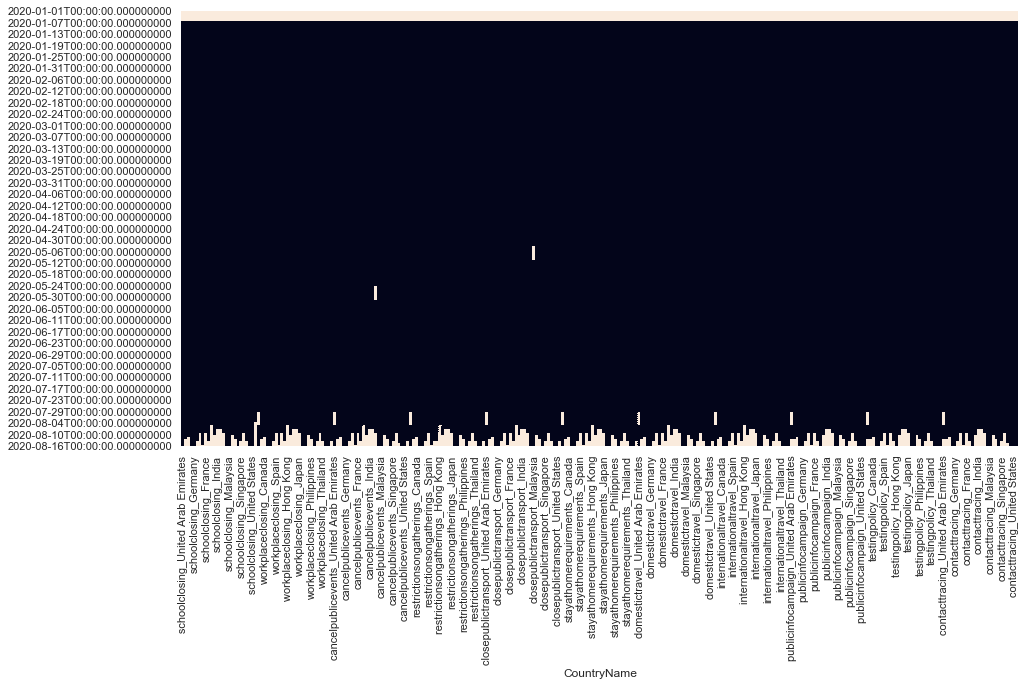

In [319]:
sns.heatmap(exogenas.isnull(), cbar=False)

In [320]:
# Interpolate missing data:
exogenas = exogenas.interpolate(method="linear", limit_direction='both')

In [321]:
exogenas.isnull().sum().sum() 

0

In [322]:
exogenas.shape

(232, 286)

# Downloading and preparing the mask wearing data (YouGov)

In [323]:
# We download the mask wearing data
url2 = "https://drive.google.com/file/d/15S6nC4NKDnTj-P6jCcf1LAoH7bgoIzEv/view?usp=sharing"
path2 = 'https://drive.google.com/uc?export=download&id='+url2.split('/')[-2]
var_percent_mask = pd.read_csv(path2, sep=";", parse_dates=['DateTime'], index_col=['DateTime'])

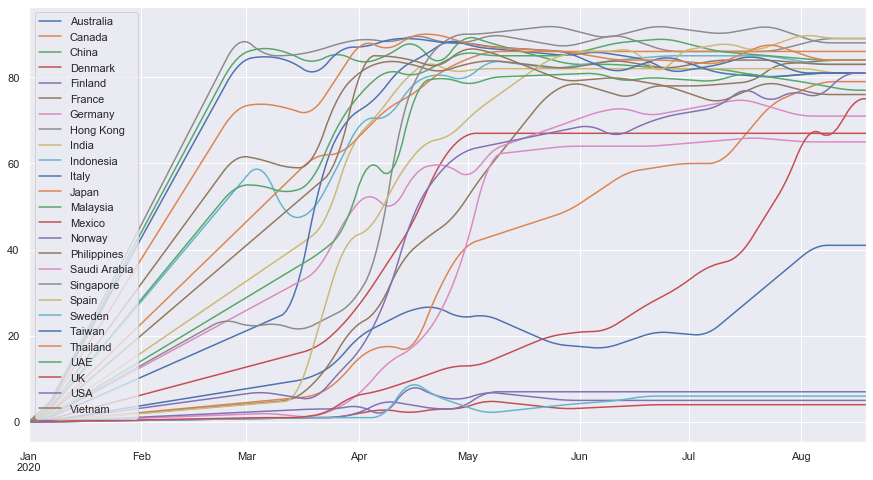

In [324]:
# We extend the dates to match those of the general exogenous dataframe, apply 7-rolling mean and
# we interpolate to fill all the missing values (initializing the series at 0):
var_percent_mask.index = pd.to_datetime(var_percent_mask.index).date
var_percent_mask = var_percent_mask.reindex(exogenas.index)
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear', limit_direction='both')
var_percent_mask = var_percent_mask.rolling(7).mean()
var_percent_mask.iloc[0] = 0
var_percent_mask = var_percent_mask.interpolate(method='linear', limit_direction='both')
var_percent_mask.plot()

In [325]:
#rename the variable's columns to be added in the general dataframe
var_percent_mask.columns = "mask_" + var_percent_mask.columns
var_percent_mask.rename(columns={"mask_UAE" : "mask_United Arab Emirates", "mask_UK":"mask_United Kingdom", "mask_USA" : "mask_United States"}, inplace=True)

In [326]:
#add the mask data to the rest of exogenous dataframe
exogenas = pd.concat([exogenas,var_percent_mask],axis=1)

In [327]:
exogenas.isnull().sum().sum()

0

In [328]:
exogenas.shape

(232, 312)

# Downloading and preparing the Flights data (we only have it available for Europe)

In [262]:
#Downloading daily flights from Eurocontrol
#url3 = "https://drive.google.com/file/d/1jLzSGGbQY8OyD1YTNZAJFRmvxy7lA2V_/view?usp=sharing"
#path3 = 'https://drive.google.com/uc?export=download&id='+url3.split('/')[-2]
url3 = 'https://ansperformance.eu/download/xls/Airport_Traffic.xlsx'
flights = pd.read_excel(url3, sheet_name="DATA", date_parser="FLT_DATE", index_col ="FLT_DATE")

In [329]:
# Extracting the number of arrival flights for the selected countries:
for i in countries.split('|'):
    flights_country = flights[flights["STATE_NAME"]==i]
    flights_country = flights_country.resample("1D").sum()
    flights_country_arr = flights_country['FLT_ARR_1'].truncate(initialdate, enddate)
    flights_country_arr.rename("FlightsArr_{}".format(i),inplace=True)
    exogenas = pd.concat([exogenas, flights_country_arr], axis=1)

In [330]:
# We interpolate the missing values at the end of the data (daily flights are only published once a month):

exogenas.loc[:, exogenas.columns.str.contains('Flights')] = exogenas.loc[:, exogenas.columns.str.contains('Flights')].rolling(7).mean()
exogenas.loc[:, exogenas.columns.str.contains('Flights')] = exogenas.loc[:, exogenas.columns.str.contains('Flights')].interpolate(method='linear', limit_direction='both')

In [331]:
# We keep the data up to the last European country (which is UK), since this data comes from Eurocontrol, only for European countries:
exogenas = exogenas.loc[:, :'FlightsArr_United Kingdom']

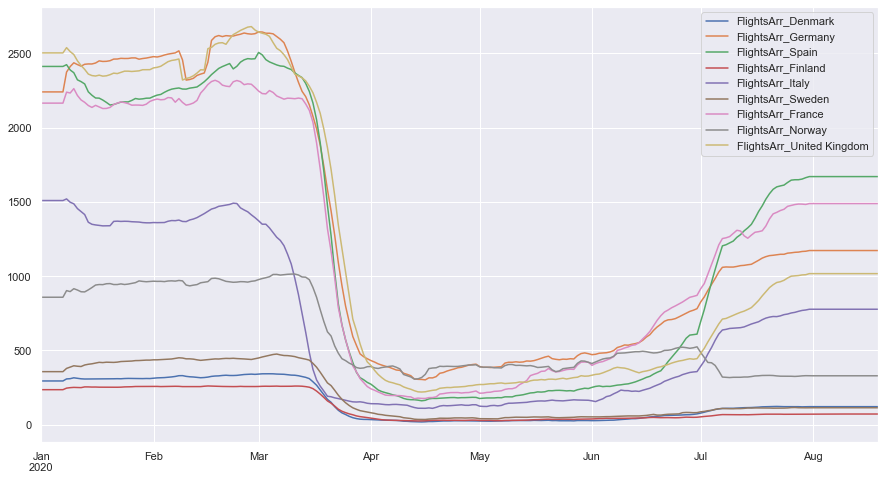

In [332]:
exogenas.loc[:, exogenas.columns.str.contains('Flights')].plot()

In [333]:
exogenas.isnull().sum().sum()

0

In [334]:
exogenas.shape

(232, 321)

# Downloading and preparing the testing data (from Our World in Data)

In [335]:
covid = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv", parse_dates=["date"], index_col="date")

In [336]:
b = 0
coviddata = []
for i in countries.split('|'):
    covid_country = covid[covid["location"]==i]
    covid_country_positive_rate = covid_country['positive_rate'].truncate(initialdate, enddate)
    covid_country_positive_rate.rename("Positive_rate_{}".format(i), inplace=True)
    if b == 0:
        coviddata = covid_country_positive_rate
        b = 1
    else:
        coviddata = pd.concat([coviddata,covid_country_positive_rate], axis=1)

In [337]:
# Drop China and Hong Kong since there is no data for those countries:
coviddata = coviddata.drop("Positive_rate_China", axis=1) 
coviddata = coviddata.drop("Positive_rate_Hong Kong", axis=1)

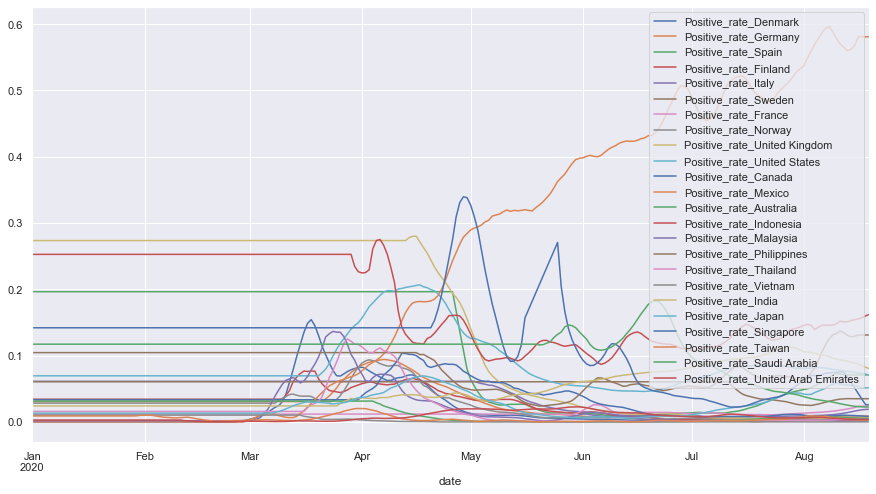

In [338]:
coviddata = coviddata.rolling(7).mean().interpolate(method='linear', limit_direction='both')
coviddata.plot()

In [106]:
#columnas = pd.Series(coviddata.columns[coviddata.columns.str.contains('Positive_rate', regex=True)])
#columnas = pd.concat([columnas,"dummy_"+columnas]) #name for the columns for the imputer in sklearn

In [107]:
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
#imp_mean_fpd = pd.DataFrame(imp_mean.fit_transform(coviddata), index=coviddata.index, columns=columnas)
#exogenas = pd.concat([exogenas,imp_mean_fpd], axis=1)

In [339]:
exogenas = pd.concat([exogenas,coviddata], axis=1)

In [ ]:
# we need to look at this again... the way Mexico is filled is not useful. 

In [341]:
exogenas.isnull().sum().sum()

0

In [342]:
exogenas.shape

(232, 345)

In [343]:
#creating the csv file
exogenas.to_csv('./data/exogenas.csv')